In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
import zipfile
from skimage.filters import laplace, sobel
import os
import cv2
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from matplotlib import pyplot as plt
import seaborn as sns

In [4]:
#Estrazione dei file nell'ambiente Colab
image_data = zipfile.ZipFile('/content/gdrive/MyDrive/Digital/archive.zip')
image_data.extractall()
image_data.close()

# VGG

In [5]:
import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import numpy as np

import random as python_random

from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam

In [6]:
!pip install split-folders
import splitfolders
splitfolders.ratio('blur_dataset_scaled', output="output", seed=1337, ratio=(0.7, 0.2, 0.1))

Copying files: 1050 files [00:02, 390.35 files/s]


In [7]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

In [8]:
path_train='/content/output/train/'
path_val='/content/output/val/'
path_test='/content/output/test/'

In [9]:
train_dataset = keras.preprocessing.image_dataset_from_directory(path_train,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

val_dataset = keras.preprocessing.image_dataset_from_directory(path_val,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

test_dataset = keras.preprocessing.image_dataset_from_directory(path_test,
                                                            image_size=(224,224),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            validation_split = False,
                                                            shuffle=True,
                                                            seed=1)

Found 732 files belonging to 3 classes.
Found 210 files belonging to 3 classes.
Found 108 files belonging to 3 classes.


In [10]:
class_names = train_dataset.class_names
print(class_names)

['defocused_blurred', 'motion_blurred', 'sharp']


In [11]:
num_classes=3

## VGG_1 = VGG without layers

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=True)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_1 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


vgg_1.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_1 = vgg_1.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_1 = loss, accuracy = vgg_1.evaluate(test_dataset)

#resnet_au_1.save('drive/MyDrive/FDL/resnet_RMS_na.h5')

553467096/553467096 [==============================] - 17s 0us/step
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
 1 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_11 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, 1000)              138357544 
                                                                 
 dense_21 (Dense)            (None, 3)                 3003      
                                                        

### Evaluation

In [ ]:
evaluate_1

[1.0519399642944336, 0.49074074625968933]

### Accuracy and Loss graphs

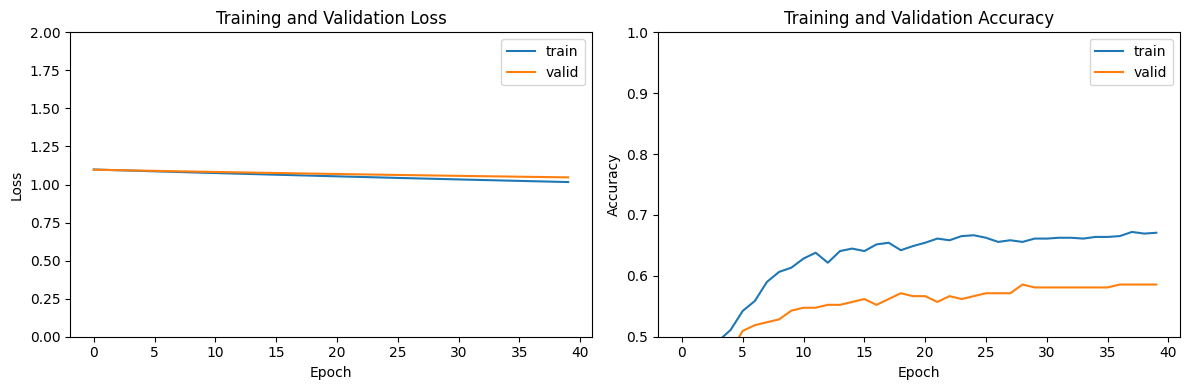

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_1.history['loss'])
plt.plot(history_vgg_1.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_1.history['accuracy'])
plt.plot(history_vgg_1.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()


##VGG_2 = VGG_1 + layer conv + global avg pooling + batchnorm

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

#x = keras.layers.BatchNormalization()(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

#x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_2 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])


vgg_2.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_2 = vgg_2.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_2 = loss, accuracy = vgg_2.evaluate(test_dataset)

#resnet_au_1.save('drive/MyDrive/FDL/resnet_RMS_na.h5')

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
 3 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_13 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_3 (Conv2D)           (None, 5, 5, 64)          294976    
                                                                 
 global_average_pooling2d_1  (None, 64)                0  

### Evaluation

In [ ]:
evaluate_2

[0.6441267728805542, 0.7592592835426331]

### Accuracy and Loss graphs

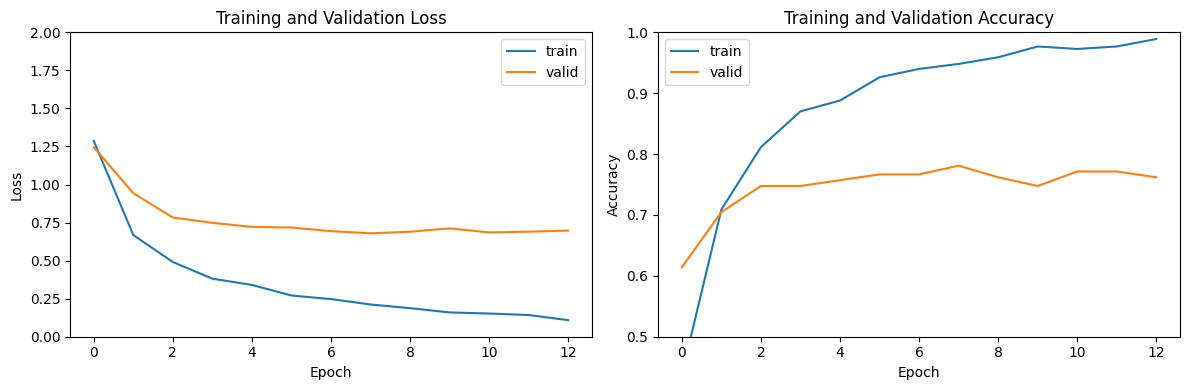

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_2.history['loss'])
plt.plot(history_vgg_2.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_2.history['accuracy'])
plt.plot(history_vgg_2.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()


## VGG_3 = VGG_2 + dense layer

In [ ]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

#x = keras.layers.BatchNormalization()(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
#x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_3 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


vgg_3.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_3 = vgg_3.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_3 = loss, accuracy = vgg_3.evaluate(test_dataset)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          294976    
                                                                 
 global_average_pooling2d_3  (None, 64)                0   

### Evaluation

In [ ]:
evaluate_3

[0.8428587317466736, 0.7870370149612427]

### Accuracy and Loss graphs

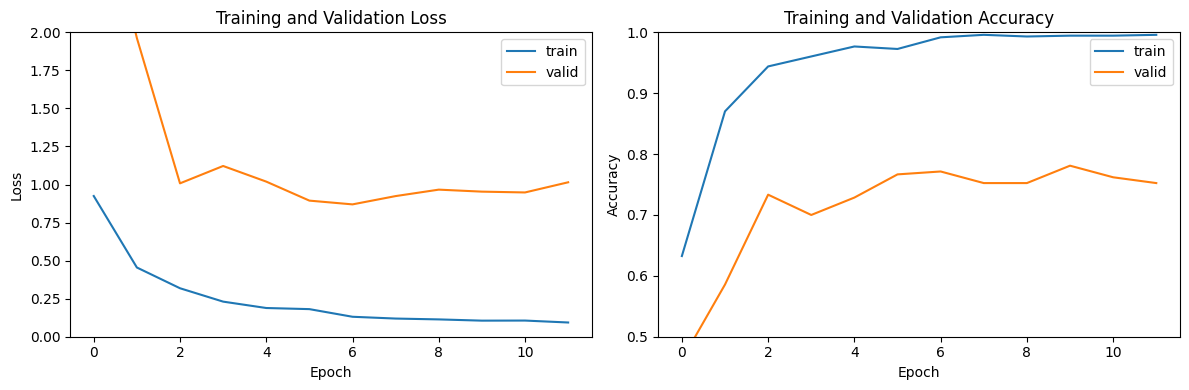

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_3.history['loss'])
plt.plot(history_vgg_3.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_3.history['accuracy'])
plt.plot(history_vgg_3.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()

## VGG_4 = VGG_3 + dropout

In [12]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
#x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

#x = keras.layers.BatchNormalization()(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_4 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_4.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


vgg_4.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_4 = vgg_4.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_4 = loss, accuracy = vgg_4.evaluate(test_dataset)

58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          294976    
                                                              

### Evaluation

In [13]:
evaluate_4

[0.9796028137207031, 0.7777777910232544]

### Accuracy and Loss graphs

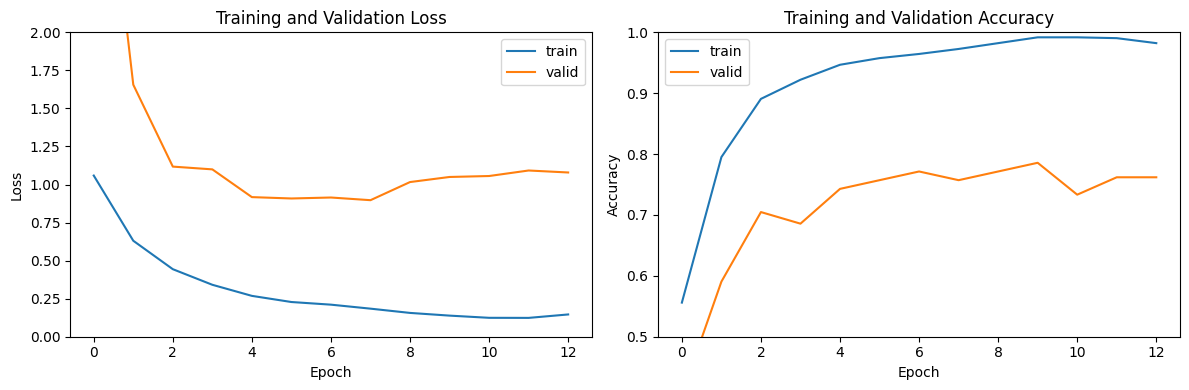

In [14]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_4.history['loss'])
plt.plot(history_vgg_4.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_4.history['accuracy'])
plt.plot(history_vgg_4.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()

## VGG_5 = VGG_4 + maxpooling + batchnorm

In [15]:
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.Conv2D(128, (3, 3), activation='relu')(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = keras.layers.BatchNormalization()(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_5 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_5.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


vgg_5.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_5 = vgg_5.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_5 = loss, accuracy = vgg_5.evaluate(test_dataset)

#resnet_au_1.save('drive/MyDrive/FDL/resnet_RMS_na.h5')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_1 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 conv2d_1 (Conv2D)           (None, 5, 5, 128)         589952    
                                                                 
 max_pooling2d (MaxPooling2  (None, 2, 2, 128)         0   

### Evaluation

In [16]:
evaluate_5

[1.0649476051330566, 0.7685185074806213]

### Accuracy and Loss graphs

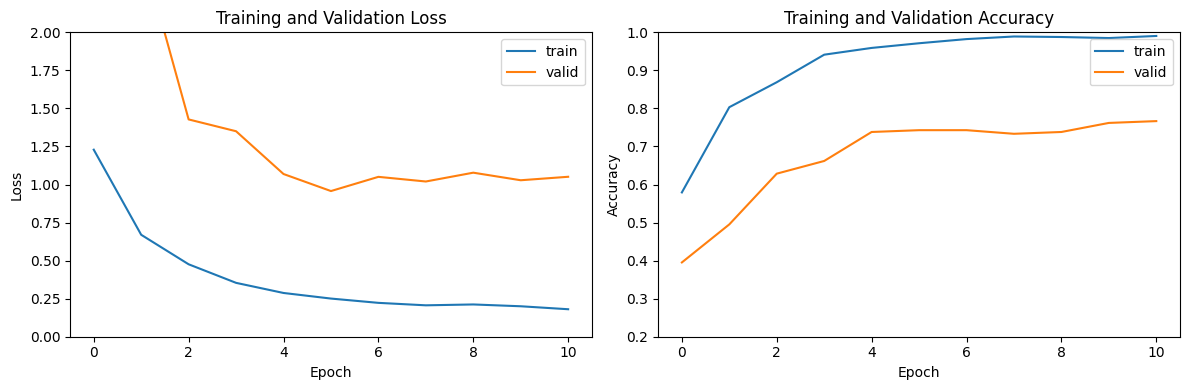

In [17]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_5.history['loss'])
plt.plot(history_vgg_5.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_5.history['accuracy'])
plt.plot(history_vgg_5.history['val_accuracy'])
plt.ylim([0.2, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()

## VGG_6 = VGG_1 + global avg pooling + batchnorm + dense layer + dropout

In [ ]:
# number of dense nodes
num_dense = [128, 256, 512]


histories_vgg_6 = []
evaluate_6 = []

for dense in num_dense:
    # Create the model
    vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


    for layer in vgg_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = keras.applications.vgg16.preprocess_input(x)
    x = vgg_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(dense, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.5)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    vgg_6 = keras.Model(inputs=inputs, outputs=outputs)

    from tensorflow.keras.optimizers import Adam
    # Compile the model
    vgg_6.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

    vgg_6.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_vgg_6 = vgg_6.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = vgg_6.evaluate(test_dataset)
    evaluate_6.append(evaluate)

    #vgg_dense.save('drive/MyDrive/FDL/resnet_Adam_dense_{}.h5'.format(dense))

    histories_vgg_6.append(history_vgg_6)


Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
 4 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_14 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 2 (GlobalAveragePooling2D)                                      
                                                          

### Evaluation

In [ ]:
evaluate_6

[[0.7626892328262329, 0.7870370149612427],
 [0.8687031865119934, 0.7870370149612427],
 [1.0032938718795776, 0.7777777910232544]]

### Accuracy and Loss graphs


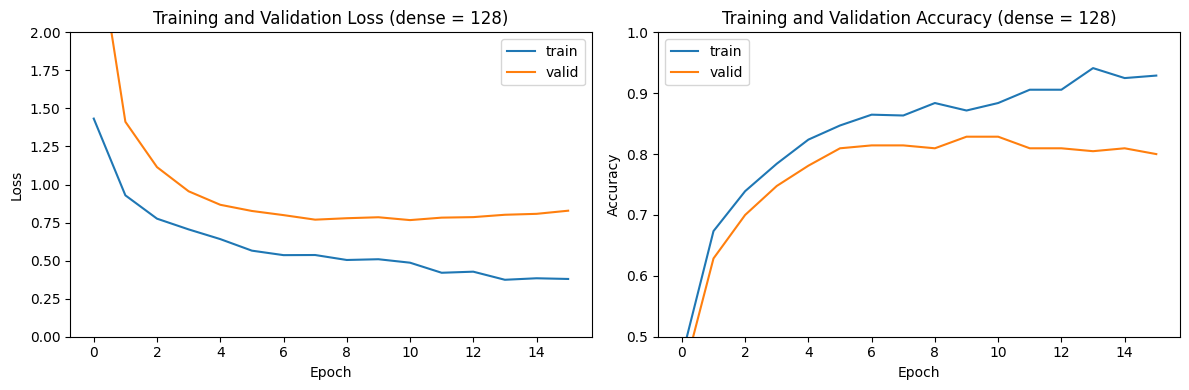

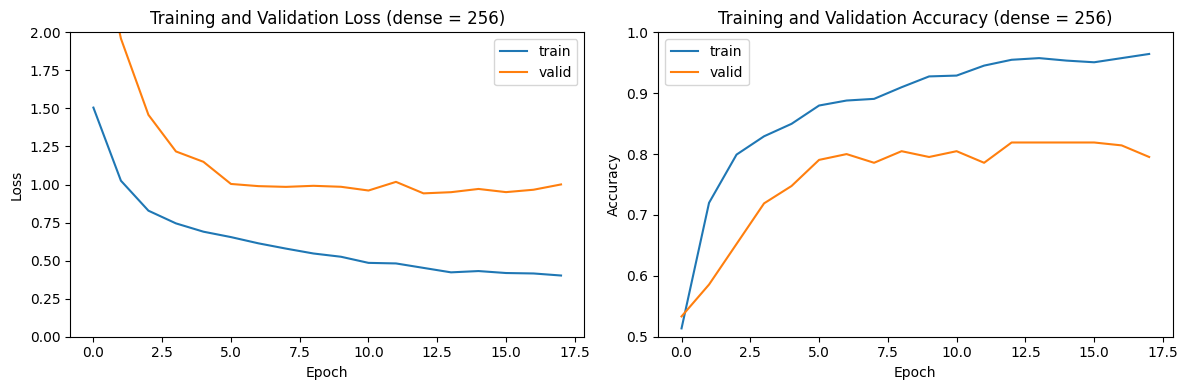

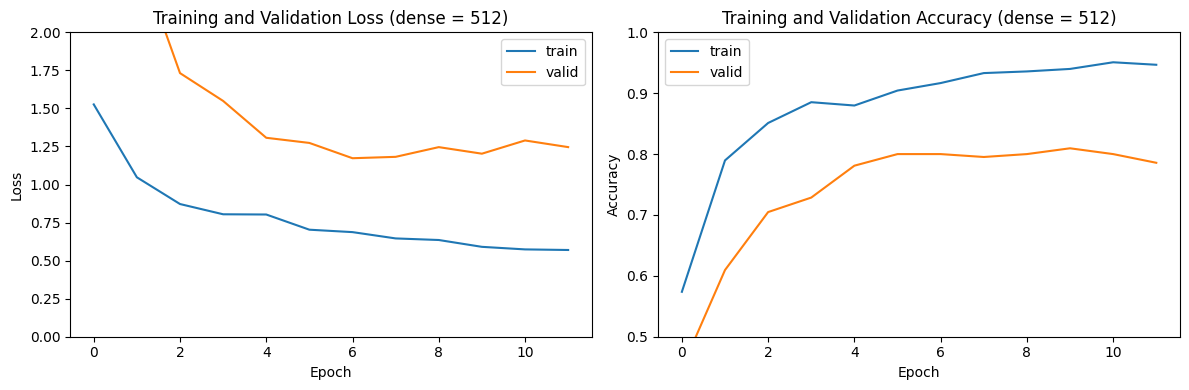

In [ ]:
for i, history in enumerate(histories_vgg_6):
    dense = num_dense[i]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid' ])
    plt.title(f'Training and Validation Loss (dense = {dense})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (dense = {dense})');

    plt.tight_layout()
    plt.show()


### Comparison Accuracy and Loss values on validation set

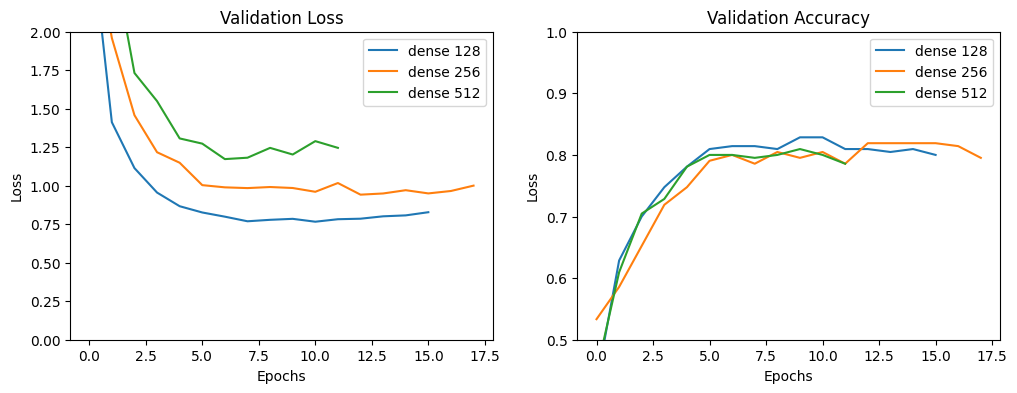

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

for i, history in enumerate(histories_vgg_6):
    plt.plot(history.history['val_loss'], label='dense {}'.format(num_dense[i]))
plt.ylim([0, 2.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()


plt.subplot(1, 2, 2)
for i, history in enumerate(histories_vgg_6):
    plt.plot(history.history['val_accuracy'], label='dense {}'.format(num_dense[i]))
plt.ylim([0.5, 1.0])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Accuracy')
plt.legend()


## VGG_7 = VGG_6 with different dropout

In [ ]:
# number of dense nodes
num_dense = [128, 256, 512]


histories_vgg_7 = []
evaluate_7 = []

for dense in num_dense:
    # Create the model
    vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


    for layer in vgg_model.layers:
        layer.trainable = False

    from keras import regularizers

    inputs = keras.Input(shape=(224, 224, 3))
    x = inputs
    x = keras.applications.vgg16.preprocess_input(x)
    x = vgg_model(x)
    x = keras.layers.GlobalAveragePooling2D()(x)


    x = keras.layers.BatchNormalization()(x)

    x = keras.layers.Dense(dense, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
    x = keras.layers.Dropout(0.1)(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
    vgg_7 = keras.Model(inputs=inputs, outputs=outputs)

    from tensorflow.keras.optimizers import Adam
    # Compile the model
    vgg_7.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

    vgg_7.summary()

    callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

    # train the model
    history_vgg_7 = vgg_7.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

    evaluate = loss, accuracy = vgg_7.evaluate(test_dataset)
    evaluate_7.append(evaluate)

    #vgg_dense.save('drive/MyDrive/FDL/resnet_Adam_dense_{}.h5'.format(dense))

    histories_vgg_7.append(history_vgg_7)


Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1  (None, 224, 224, 3)       0         
 7 (SlicingOpLambda)                                             
                                                                 
 tf.nn.bias_add_17 (TFOpLam  (None, 224, 224, 3)       0         
 bda)                                                            
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
 5 (GlobalAveragePooling2D)                                      
                                                          

### Evaluation

In [ ]:
evaluate_7

[[0.8658832311630249, 0.7777777910232544],
 [0.9636437892913818, 0.7870370149612427],
 [1.1179815530776978, 0.8055555820465088]]

### Accuracy and Loss graphs

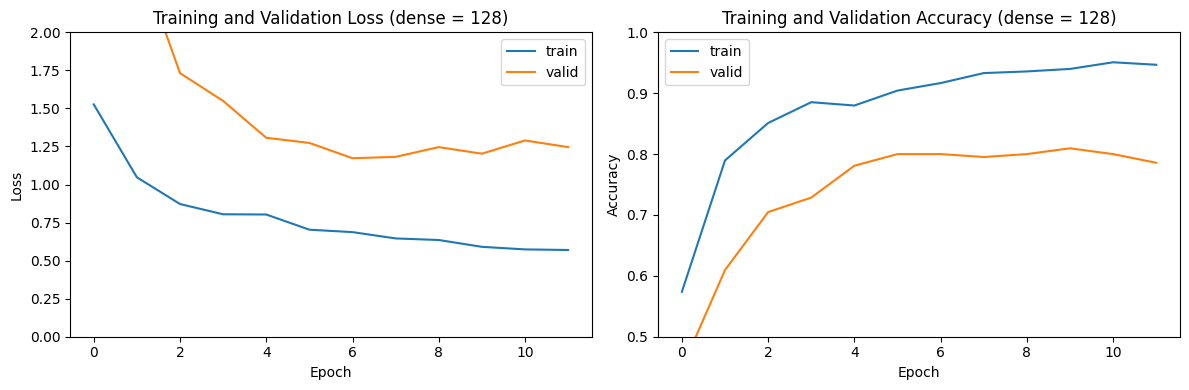

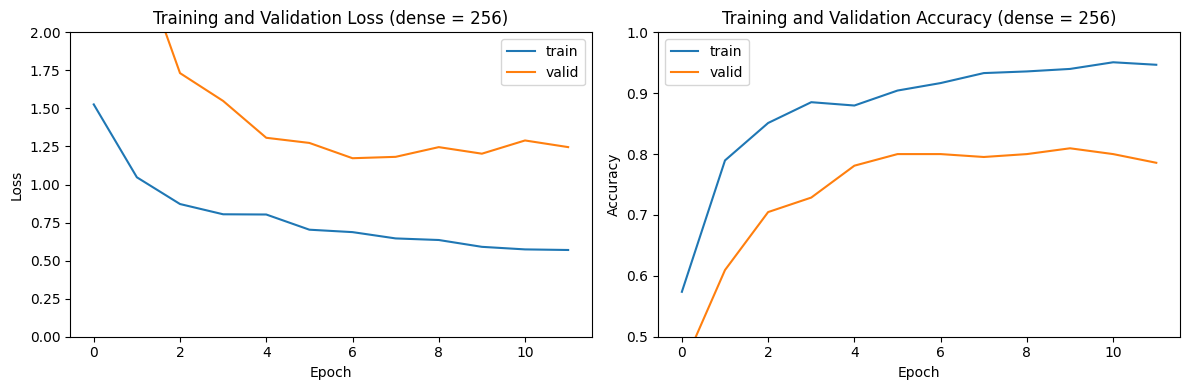

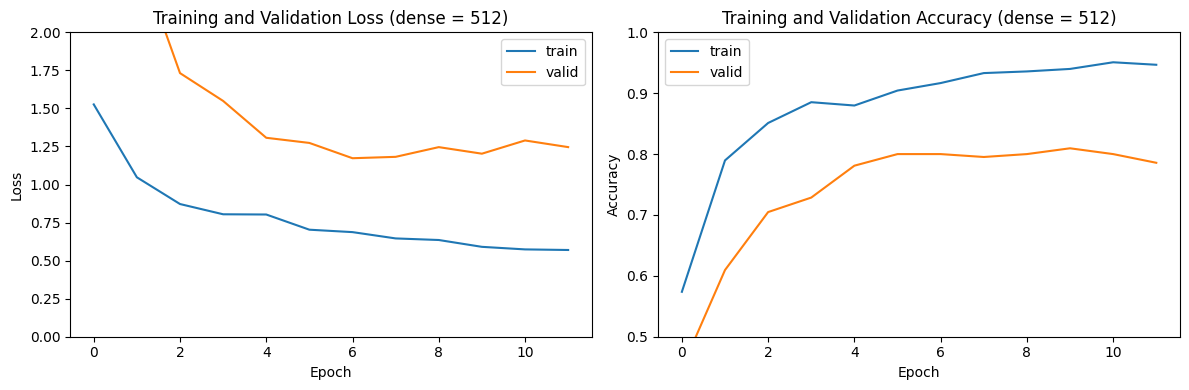

In [ ]:
for i, history in enumerate(histories_vgg_7):
    dense = num_dense[i]

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylim([0, 2.0])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['train', 'valid' ])
    plt.title(f'Training and Validation Loss (dense = {dense})');


    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['train', 'valid'])
    plt.title(f'Training and Validation Accuracy (dense = {dense})');

    plt.tight_layout()
    plt.show()


### Comparison Accuracy and Loss values on validation set

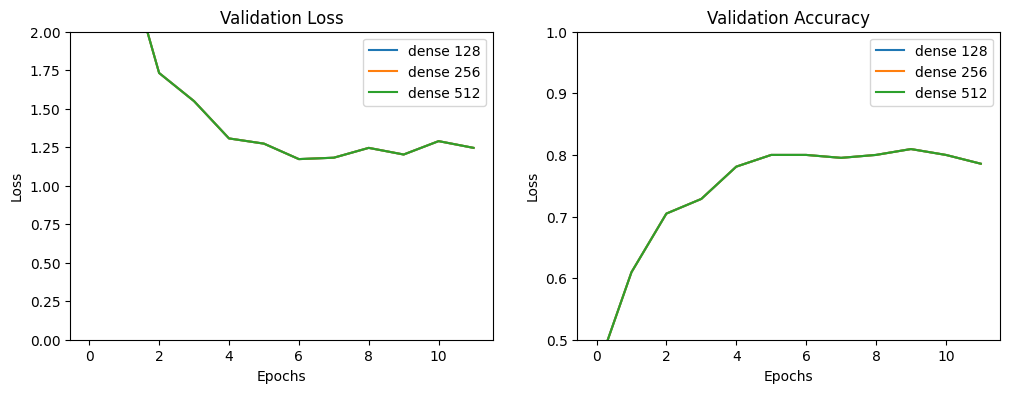

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)

for i, history in enumerate(histories_vgg_7):
    plt.plot(history.history['val_loss'], label='dense {}'.format(num_dense[i]))
    plt.ylim([0, 2.0])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Loss')
    plt.legend()


plt.subplot(1, 2, 2)
for i, history in enumerate(histories_vgg_7):
    plt.plot(history.history['val_accuracy'], label='dense {}'.format(num_dense[i]))
    plt.ylim([0.5, 1.0])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Validation Accuracy')
    plt.legend()

## augmentation

In [18]:
data_augmentation_1 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
        layers.RandomCrop(224,224)
    ]
)

def random_channel_flip(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

data_augmentation_2 = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomTranslation(0.1, 0.1),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
        layers.GaussianNoise(0.1),
        layers.Lambda(random_channel_flip),

    ]
)

### VGG_6 + first augmentation

In [19]:
vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = data_augmentation_1(x)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_au_1 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_au_1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


vgg_au_1.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_au_1 = vgg_au_1.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_a1 = loss, accuracy = vgg_au_1.evaluate(test_dataset)

#resnet_au_1.save('drive/MyDrive/FDL/resnet_RMS_na.h5')

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0   

### Evaluation

In [20]:
evaluate_a1

[1.192736029624939, 0.7685185074806213]

### Accuracy and Loss graphs

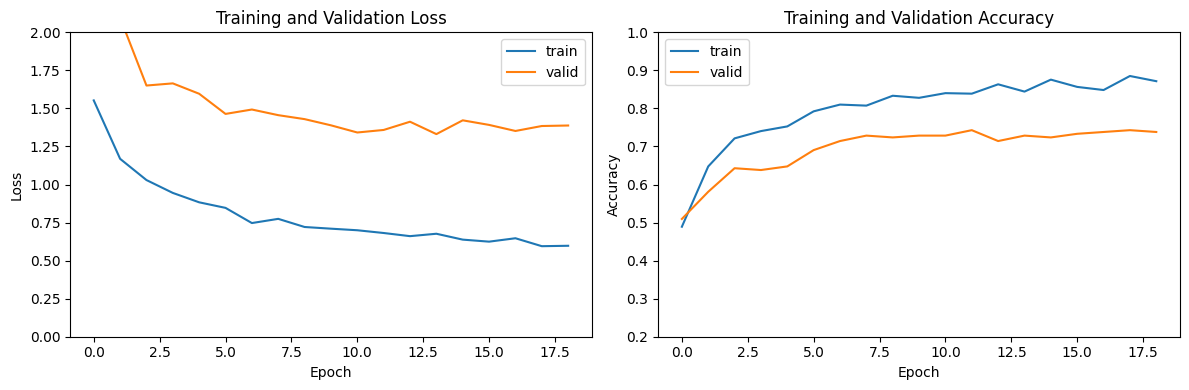

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_au_1.history['loss'])
plt.plot(history_vgg_au_1.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_au_1.history['accuracy'])
plt.plot(history_vgg_au_1.history['val_accuracy'])
plt.ylim([0.2, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()

### VGG_6 + second augmentation

In [22]:
vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = data_augmentation_2(x)
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)

x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_au_2 = keras.Model(inputs=inputs, outputs=outputs)



# Compile the model
vgg_au_2.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])


vgg_au_2.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_au_2 = vgg_au_2.fit(train_dataset,
          epochs=40,
          validation_data=val_dataset,
          callbacks=[callback])

evaluate_a2 = loss, accuracy = vgg_au_2.evaluate(test_dataset)

#resnet_au_2.save('drive/MyDrive/FDL/resnet_RMS_na.h5')

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_3  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_3 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_3  (None, 512)               0   

### evaluation

In [23]:
evaluate_a2

[1.1130304336547852, 0.7407407164573669]

### accuracy and loss graphs

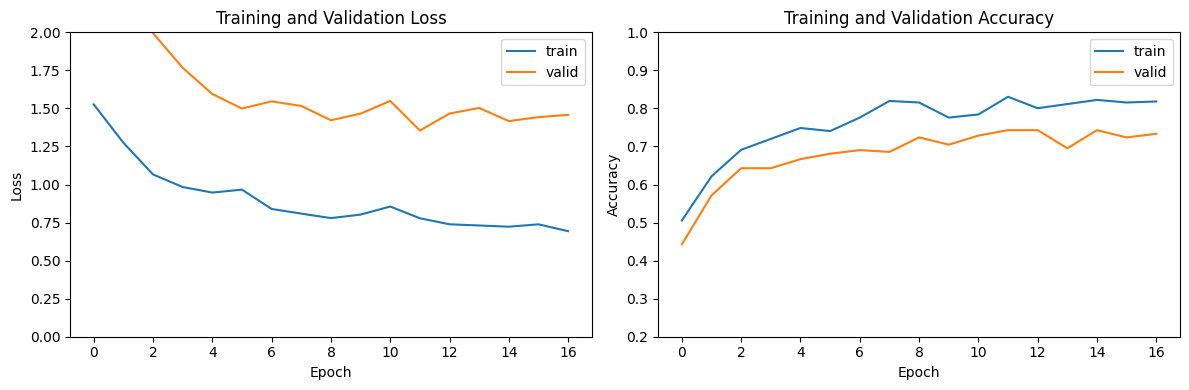

In [24]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg_au_2.history['loss'])
plt.plot(history_vgg_au_2.history['val_loss'])
plt.ylim([0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid' ])
plt.title(f'Training and Validation Loss');


plt.subplot(1, 2, 2)
plt.plot(history_vgg_au_2.history['accuracy'])
plt.plot(history_vgg_au_2.history['val_accuracy'])
plt.ylim([0.2, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])
plt.title(f'Training and Validation Accuracy');

plt.tight_layout()
plt.show()

## best result

In [25]:
vgg_model = keras.applications.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)


for layer in vgg_model.layers:
    layer.trainable = False

from keras import regularizers

inputs = keras.Input(shape=(224, 224, 3))
x = inputs
x = keras.applications.vgg16.preprocess_input(x)
x = vgg_model(x)
x = keras.layers.GlobalAveragePooling2D()(x)


x = keras.layers.BatchNormalization()(x)

x = keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.BatchNormalization()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)
vgg_best = keras.Model(inputs=inputs, outputs=outputs)

from tensorflow.keras.optimizers import Adam
# Compile the model
vgg_best.compile(loss=keras.losses.categorical_crossentropy,
          optimizer=Adam(learning_rate=0.001),
          metrics=['accuracy'])

vgg_best.summary()

callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# train the model
history_vgg_best = vgg_best.fit(train_dataset,
      epochs=40,
      validation_data=val_dataset,
      callbacks=[callback])

evaluate_best = loss, accuracy = vgg_best.evaluate(test_dataset)



Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_4  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_4 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_4  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                           

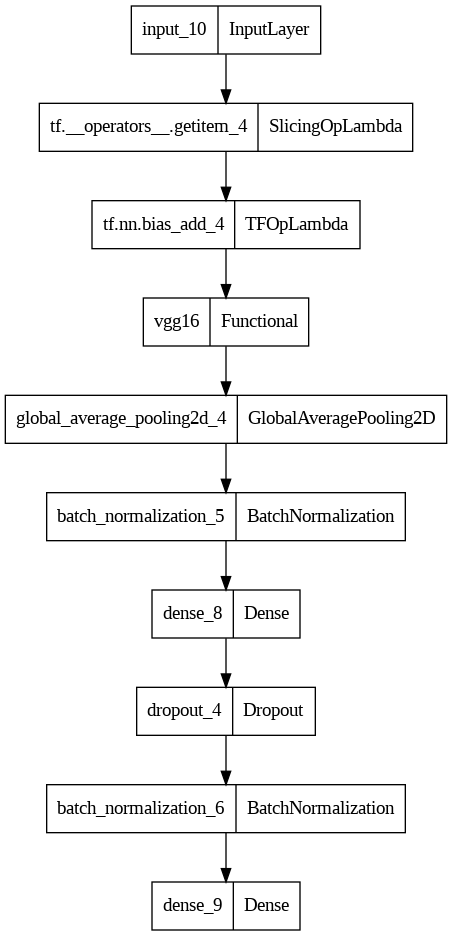

In [26]:
keras.utils.plot_model(vgg_best, to_file="VGG_best.png")

In [27]:
evaluate_best

[0.7070111036300659, 0.7870370149612427]

In [28]:
vgg_best.save('/content/drive/MyDrive/Digital/VGG.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Missclassified images

In [29]:
errate=0
for images, labels in test_dataset:
    for i in range( images.shape[0]):
        predictions = vgg_best.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          errate+=1
print(f'Number of images classifacated wrong: {errate}')

Number of images classifacated wrong: 23


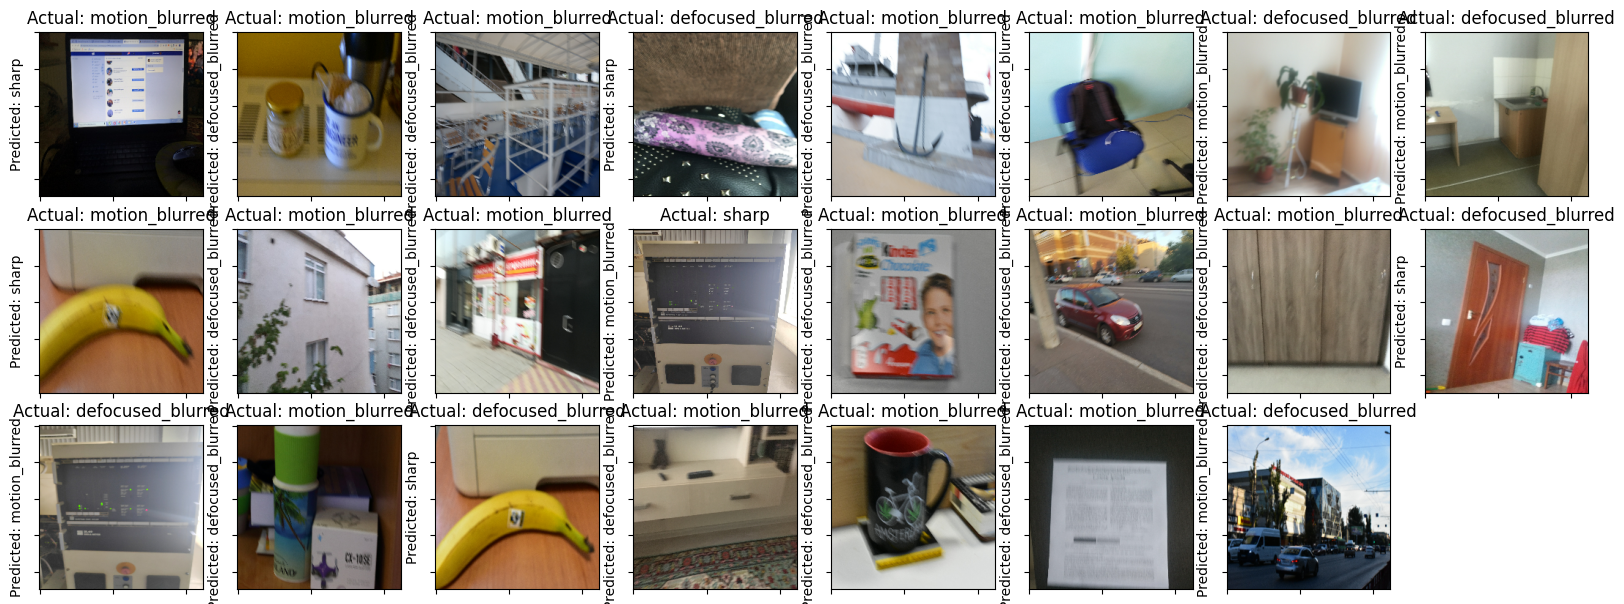

In [30]:
j=0
plt.figure(figsize=(20, 20))
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predictions = vgg_best.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        if class_names[np.argmax(score)] != class_names[np.argmax(labels[i], axis=None, out=None)]:
          ax = plt.subplot(8, 8, j+1)
          plt.imshow(images[i].numpy().astype("uint8"))
          plt.ylabel("Predicted: "+class_names[np.argmax(score)])
          plt.title("Actual: "+class_names[np.argmax(labels[i], axis=None, out=None)])
          plt.gca().axes.yaxis.set_ticklabels([])
          plt.gca().axes.xaxis.set_ticklabels([])
          j+=1

### Confusion Matrix

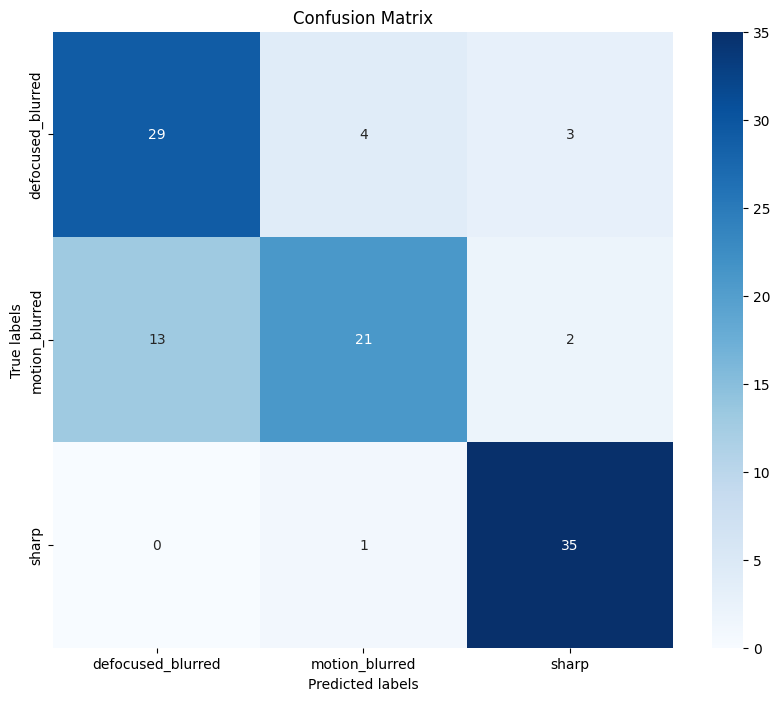

In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Creare le liste per le etichette reali e previste
y_true = []
y_pred = []

for images, labels in test_dataset:
    for i in range(images.shape[0]):
        predictions = vgg_best.predict(tf.expand_dims(images[i], 0), verbose=0, steps=1)
        score = tf.nn.softmax(predictions[0])
        y_true.append(np.argmax(labels[i]))
        y_pred.append(np.argmax(score))

# Calcolare la confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

